# Format RETREAT data as STAC catalog

- following example in TDS article
- downloaded locally as GEOTIFFs


In [1]:
from pathlib import Path
import stackstac
import xarray as xr
import glob
import shutil
import pystac
from itertools import groupby
from shapely.geometry import Polygon, mapping
import rasterio as rio
import os
import pandas as pd
from rasterio.warp import transform_bounds, transform_geom
from pystac.extensions import item_assets 
from pystac.extensions.projection import AssetProjectionExtension



In [2]:
!pwd

/home/emmamarshall/Desktop/phd_work/retreat/retreat/code


In [3]:
pystac.__version__

'1.6.1'

## Util functions

In [4]:
def parse_fname(fposix):
    '''extract relevant metadata from filename and return it as variables that will be used when creating stac items
    note function takes `pathlib.PosixPath` objects, not strs
    '''
    fname = fposix.stem
    prevar = fname.split('-')[0]
    var = fname.split('-')[1].split('+')[0]
    post_var = fname.split('-')[1].split('+')[1]
    
    sensor = post_var[:2]
    #tried formating acq,sec date as datetime at first but catalog won't save if property objects are datetimes, it seems 
    
    temp = post_var.split('S1_')
    ref_date = temp[1].split('_')[0]
    ref_id = temp[1].split('_')[1]
    sec_date = temp[2].split('_')[0]
    sec_id = temp[2].split('_')[1]
    
    site = prevar[:2]
    frame = prevar[3:6]
    orbit = prevar[7:10]
    mid_date = pd.to_datetime(prevar[11:19])
    
   
    
    return sensor, ref_date, ref_id, sec_date, sec_id, site, orbit, frame, mid_date

In [5]:
#fn from TDS article
def get_bbox_and_footprint(dataset):
    #create boundingbox, will depent on if it comes from rasterio or rioxarray
    
    bounds = dataset.bounds
    
    if isinstance(bounds, rio.coords.BoundingBox):
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
    else:
        bbox = [float(f) for f in bounds()]
    
    #create footprint
    footprint = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]]
    ])
    return bbox, mapping(footprint)

    return bbox, mapping(footprint)

In [6]:
!pwd

/home/emmamarshall/Desktop/phd_work/retreat/retreat/code


In [7]:
#get list of files
#folder = Path('/uufs/chpc.utah.edu/common/home/u1269862/2023/retreat/data/')
folder = Path('/home/emmamarshall/Desktop/phd_work/retreat/data/')


In [8]:
folder

PosixPath('/home/emmamarshall/Desktop/phd_work/retreat/data')

## Folder setup - only run 1x

In [9]:
files_ls = os.listdir(folder)

In [10]:
files_ls = [x for x in files_ls if not '.ipynb_checkpoints' in x]

In [11]:
files_ls[0][:10]

'10_085_053'

Need to group the files by footprint/ tile

In [12]:
#make a list of all the diff footprint ids
footprint_ids = set([x[:10] for x in files_ls])

In [13]:
footprint_ids 

{'10_019_001',
 '10_019_010',
 '10_019_019',
 '10_019_030',
 '10_019_043',
 '10_019_044',
 '10_019_045',
 '10_019_066',
 '10_019_069',
 '10_019_085',
 '10_085_002',
 '10_085_005',
 '10_085_015',
 '10_085_017',
 '10_085_028',
 '10_085_038',
 '10_085_053'}

make a dir for each tile:

In [14]:
!pwd

/home/emmamarshall/Desktop/phd_work/retreat/retreat/code


In [15]:
#gen_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/retreat/data/'
gen_path = '/home/emmamarshall/Desktop/phd_work/retreat/data/'
for element in footprint_ids:
    full_path = os.path.join(gen_path, element)
    os.makedirs(full_path, exist_ok=True)
    

Now need to move files into appropriate sub-dirs:

In [147]:
def move_files_to_tile_subdir(tile):
    
    for data in glob.glob(f'{gen_path}{tile}*'):
        shutil.move(data, f'{gen_path}/{tile}/')
#https://stackoverflow.com/questions/28913088/moving-files-with-wildcards-in-python   

In [148]:
for tile in footprint_ids:
    move_files_to_tile_subdir(tile)

In [149]:
#move_files_to_tile_subdir('10_019_001')

In [150]:
#this will group all the files in the dir by the footprint ID (first 10 elements)
grouped = [list(g) for k,g in groupby(files_ls, lambda  s: s[:10])]

## Make STAC catalog and items

In [9]:
dis_angs = list(folder.rglob('*-dis_angle*.tif'))
dis_azs = list(folder.rglob('*-dis_az*.tif'))
dis_mags = list(folder.rglob('*-dis_mag*.tif'))
dis_N_angs = list(folder.rglob('*dis_N_ang*.tif'))
dis_rs = list(folder.rglob('*dis_r*.tif'))

In [10]:
parse_fname(dis_angs[0])

('S1',
 '20210107T122220',
 'BFF8',
 '20210119T122219',
 'DDCD',
 '10',
 '053',
 '085',
 Timestamp('2021-01-13 00:00:00'))

In [11]:
ds = xr.open_dataset(dis_angs[0], engine='rasterio').squeeze()
ds.rio.crs

CRS.from_epsg(32645)

In [20]:
ds_r.transform

Affine(200.0, 0.0, 199356.058,
       0.0, -200.0, 3251854.581)

In [12]:
catalog = pystac.Catalog(
    id = 'RETREAT data, Langtang',
    description = 'OLD RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet',
    stac_extensions = ['https://stac-extensions.github.io/projection/v1.0.0/schema.json']
)

In [13]:
var_ls = [dis_angs, dis_azs, dis_mags, dis_N_angs, dis_rs]
zero_element = [var_ls[var][0].stem[:19] for var in range(len(var_ls))]
set(zero_element)

if len(set(zero_element)) == 1:
    print('yes')
else:
    print('no')

yes


In [15]:
def build_stac_catalog_single_var(dis_angs, var_name):
    
    for dis_ang in dis_angs:

            if str(dis_ang).endswith('.tif'):

                try:
                    sensor, ref_date, ref_id, sec_date, sec_id, site, orbit, frame, mid_date = parse_fname(dis_ang)
                except: 
                    pass
                #open file with rasterio
                ds = xr.open_dataset(dis_ang, engine='rasterio').squeeze()   #bounds should be: left bottom right top

                left = ds.x.data.min()
                right = ds.x.data.max()
                bottom = ds.y.data.min()
                top = ds.y.data.max()

                #create bbox, footprint
                bbox = [left, bottom, right, top]
                footprint = Polygon([
                    [bbox[0], bbox[1]],
                    [bbox[0], bbox[3]],
                    [bbox[2], bbox[3]],
                    [bbox[2], bbox[1]]
                    ])
                footprint_m = mapping(footprint)


                #project to wgs84, optain in geometric coords
                geo_bounds = transform_bounds(ds.rio.crs, 'EPSG:4326', *bbox)
                geo_footprint = transform_geom(ds.rio.crs, 'EPSG:4326', footprint_m)

                #properties
                idx = dis_ang.stem[:19]
                #date = pd.to_datetime(dis_ang.stem[11:19])
                date = pd.to_datetime(dis_ang.stem[11:19])
                tile = dis_ang.stem[:10]

                item = pystac.Item(
                    id = idx,
                    geometry = geo_footprint,
                    bbox = geo_bounds,
                    datetime = date,
                    stac_extensions = ['https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
                    #start_datetime = ref_date,
                    #end_datetime = sec_date,
                    properties = dict(
                        tile=tile,
                        sensor = sensor,
                        ref_date = ref_date,
                        ref_id = ref_id,
                        sec_date = sec_date,
                        sec_id = sec_id,
                        site = site, 
                        orbit = orbit, 
                        frame = frame, 
                        orig_file = str(dis_ang),
                    )
            )

                catalog.add_item(item)
                idx = dis_ang.stem[:19]
                item = catalog.get_item(idx)

                #as before, open both with rasterio to get bbox, footprint
                ds = rio.open(dis_ang)
                bbox, footprint = get_bbox_and_footprint(ds)

                item.add_asset(
                    key = var_name,
                  #  title='dis_ang',
                    asset = pystac.Asset(
                        href = dis_ang.as_posix(),
                        title=var_name,
                        media_type = pystac.MediaType.GEOTIFF
                    )
                )
                #extend the asset wtih extension projection
                asset_ext = AssetProjectionExtension.ext(item.assets[var_name])
                asset_ext.epsg = ds.crs.to_epsg()
                asset_ext.shape = ds.shape
                asset_ext.bbox = bbox
                asset_ext.geometry = footprint
                asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']
            else:
                pass
    print(len(list(catalog.get_items())))

    
    

In [16]:
def stac_catalog_add_assets_singlevar(var_ls, var_name): 
    
    for file in var_ls:
        #print(file)
        if str(file).endswith('.tif'):
    
            idx = file.stem[:19]
            item = catalog.get_item(idx)
            item.extra_fields[f'orig_file_{var_name}'] = str(file)[49:]

                            #as before, open both with rasterio to get bbox, footprint
            ds = rio.open(file)
            bbox, footprint = get_bbox_and_footprint(ds)

            item.add_asset(
                key = var_name,
                #  title='dis_ang',
                asset = pystac.Asset(
                    href = file.as_posix(),
                    title=var_name,
                    media_type = pystac.MediaType.GEOTIFF
                    )
                )
                            #extend the asset wtih extension projection
            asset_ext = AssetProjectionExtension.ext(item.assets[var_name])
            asset_ext.epsg = ds.crs.to_epsg()
            asset_ext.shape = ds.shape
            asset_ext.bbox = bbox
            asset_ext.geometry = footprint
            asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']
        else:
            pass
        
    print(len(list(catalog.get_items())))


In [17]:
build_stac_catalog_single_var(dis_angs, 'dis_ang')

314


In [18]:
stac_catalog_add_assets_singlevar(dis_azs, 'dis_az')

314


In [19]:
stac_catalog_add_assets_singlevar(dis_mags, 'dis_mag')

314


In [20]:
stac_catalog_add_assets_singlevar(dis_N_angs, 'dis_N_ang')

314


In [21]:
stac_catalog_add_assets_singlevar(dis_rs, 'dis_r')

314


Now, add assets

In [66]:
list(catalog.get_all_items())[:5]

[<Item id=10_085_053_20210113>,
 <Item id=10_085_017_20150509>,
 <Item id=10_085_017_20150614>,
 <Item id=10_085_017_20150602>,
 <Item id=10_085_017_20150521>]

In [62]:
catalog

"ID: RETREAT data, Langtang"
Description: OLD RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: (83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891)"
Datetime: 2021-01-13 00:00:00
tile: 10_085_053
sensor: S1
ref_date: 20210107T122220
ref_id: BFF8
sec_date: 20210119T122219


In [22]:
catalog.normalize_hrefs('/home/emmamarshall/Desktop/phd_work/retreat/retreat/working_stac_catalog')


In [23]:
catalog.save()

## Testing

In [2]:
import json

cat = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/retreat/A37stac_catalog/catalog.json')
item = list(cat.get_items())[-1]

In [3]:
cat

"ID: RETREAT data, Langtang"
Description: OLD RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891]"
Datetime: 2021-01-13 00:00:00+00:00
tile: 10_085_053
sensor: S1
acq_date: 20210107T122220
acq_id: BFF8


In [4]:
item

ID: 10_019_085_20210720
"Bounding Box: [83.2442180150967, 27.56441954000287, 86.17114833425134, 29.71371916902088]"
Datetime: 2021-07-20 00:00:00+00:00
tile: 10_019_085
sensor: S1
acq_date: 20210714T001927
acq_id: C779
sec_date: 20210726T001927
sec_id: F61C
site: 10
orbit: 085


See if it works using stackstac (copied this fn directly from tds article)

In [87]:
def search_items(catalog, tiles, start_date, end_date, utc=True):

    # convert tiles to a list (if it is not)
    tiles = [tiles] if not isinstance(tiles, list) else tiles

    start_date = pd.to_datetime(start_date, utc=utc)
    end_date = pd.to_datetime(end_date, utc=utc)

    items = [item for item in catalog.get_items() if item.datetime > start_date and item.datetime < end_date and item.properties['tile'] in tiles]

    items = sorted(items, key=lambda x: x.datetime)

    return items

items = search_items(cat, [list(footprint_ids)[0]], '2014-01-01','2022-01-01')
len(items)

1

In [5]:
items_real = cat.get_all_items()

cube = stackstac.stack(
    items = [item.to_dict() for item in items_real])
   

In [6]:
cube

<xarray.DataArray 'stackstac-d03f1827d14da215a702b9f553bde0d7' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time       (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id         (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    orbit      (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    ...         ...
    sec_id     (time) <U4 '55_D' '54_1' '3910' '54_C' ... 'F61C' 'D582' '3830'
    sec_date   (time) <U15 'S1_20141104T122' ... '20211111T001930'
    tile       (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg  int64 32645
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [7]:
cube.isel(time=1).sel(band='dis_mag').min().compute()

<xarray.DataArray 'stackstac-d03f1827d14da215a702b9f553bde0d7' ()>
array(-3.14158273)
Coordinates: (12/15)
    time       datetime64[ns] 2014-10-31
    id         <U19 '10_019_001_20141031'
    band       <U9 'dis_mag'
    orbit      <U3 '001'
    sensor     <U2 'S1'
    acq_date   <U15 '20141019T001854'
    ...         ...
    sec_id     <U4 '54_1'
    sec_date   <U15 'S1_20141112T001'
    tile       <U10 '10_019_001'
    title      <U9 'dis_mag'
    proj:epsg  int64 32645
    epsg       int64 32645

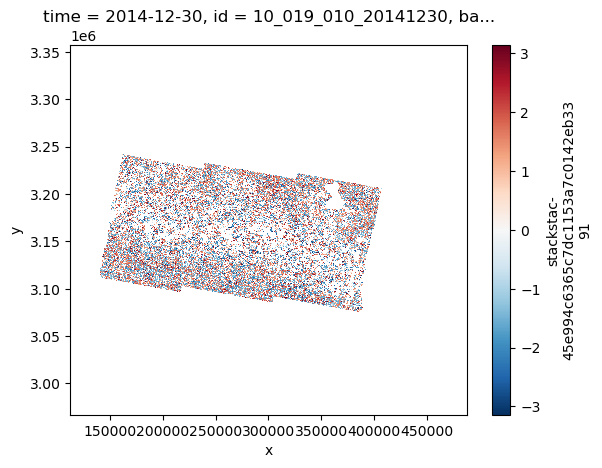

In [101]:
cube.isel(time=10).sel(band='dis_mag').plot()

In [89]:
cube = cube.load()

In [90]:
len(cube.time.data)

1

In [91]:
cube.isel(time=0)
for element in range(len(cube.time.data)):
    
    arr = cube.isel(time=element)
    mean = arr.mean().data
    print(mean)

0.008583059778822589


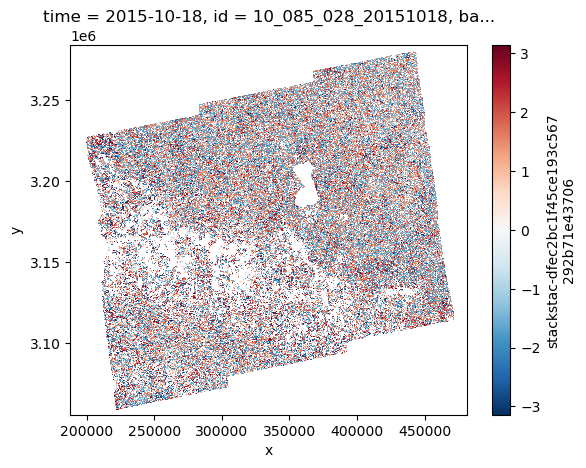

In [96]:
cube.sel(band='dis_mag').isel(time=0).plot()